# Importing libraries

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.preprocessing import StandardScaler, QuantileTransformer
# from sklearn.metrics import mean_absolute_error



In [27]:
# Change some pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("precision", 10)

# Data acquisition

In [28]:
# Read data
df_house = pd.read_csv("kc_house_data.csv")
df_house_date = df_house.drop(columns=['id','date'])
df_house = df_house.drop(columns=['id','zipcode','date'])

# Splite data to train and test df
df_train, df_test = train_test_split(df_house, test_size=0.3, random_state=33)

# Reset index for each df for later modification
# df_train.reset_index(drop=True, inplace=True)
# df_test.reset_index(drop=True, inplace=True)

# Splite data to inpdependent variables and traget
X_train, y_train = df_train.drop(columns=['price']), df_train['price']
X_test, y_test = df_test.drop(columns=['price']), df_test['price']

# Edit date feature
# df_house['date'] = df_house['date'].apply(lambda item: item[:8])
# df_house['date'] = pd.to_datetime(df_house['date'], format='%Y%m%d', errors='ignore').astype('object')

In [29]:
df_train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
7543,625000.0,2,1.00,1100,4160,1.0,0,0,3,7,1100,0,1919,0,47.6352,-122.352,1900,4000
6160,216600.0,3,1.75,2200,7700,1.0,0,0,3,7,1240,960,1975,0,47.4119,-122.181,1770,7360
6610,472500.0,3,2.50,1650,3711,2.0,0,0,3,8,1650,0,1996,0,47.6863,-122.093,1760,3762
17037,269950.0,3,2.50,1480,9743,2.0,0,0,4,7,1480,0,1996,0,47.3293,-122.001,1810,9601
18766,443000.0,3,1.75,1810,7950,1.0,0,0,4,7,1810,0,1968,0,47.6236,-122.117,1680,7725


# Data preparation

## Data checking
- check to check if the data has strange values.
- after check the data, no strange values are found.

In [30]:
def get_values_count(data:pd.DataFrame) -> None:
    """
    Calculate the values count for each feature in the DataFrame
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    
    Returns
    -------
    values_count : DataFrame contains values count for each feature
    """
    print("--Value counts in each features--")
    for col in data.columns:
        val_cnts = data[col].value_counts(dropna=False).to_dict()
        if(len(val_cnts)>15):
            continue
        print(f"{col} :{val_cnts}")


def get_unique_values(data:pd.DataFrame):
    """
    Get unique values in each feature
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    
    Returns
    -------
    unique_values : DataFrame contains unique values for each feature
    """
    print("--Unique values in each features--")
    for col in data.columns:
        unique_values = data[col].unique()
        if(len(unique_values)>100):
            continue
        print(f"{col} :{unique_values}")
    

get_unique_values(df_train)


--Unique values in each features--
bedrooms :[ 2  3  4  5  1  6 33  7  0 10  8  9 11]
bathrooms :[1.   1.75 2.5  3.25 4.75 2.25 3.5  3.   0.75 2.75 2.   1.5  4.5  3.75
 4.   5.75 5.5  5.   4.25 0.   0.5  8.   5.25 1.25 6.5  6.   6.75 6.25
 7.5 ]
floors :[1.  2.  2.5 1.5 3.  3.5]
waterfront :[0 1]
view :[0 2 1 4 3]
condition :[3 4 5 2 1]
grade :[ 7  8  6  9 10  4 11  5 12 13  3  1]
yr_renovated :[   0 1988 2013 2014 1990 1989 2000 1994 2004 1983 1964 1981 2015 2005
 1982 2003 1996 1986 1998 2001 1991 1940 2008 1995 1997 2011 1968 2002
 1999 1984 1985 2007 1967 1992 2009 1945 1980 1970 1963 1975 1944 1973
 1987 1953 1977 2010 1979 2006 1976 2012 1956 1969 1950 1958 1965 1978
 1993 1948 1955 1959 1972 1960 1962 1946 1951 1974 1934]


## Missing values

In [31]:
# Remove null values if exist
print(f"--Missing values count--\n{df_train.isnull().sum().sort_values()}")

--Missing values count--
price            0
long             0
lat              0
yr_renovated     0
yr_built         0
sqft_basement    0
sqft_above       0
grade            0
condition        0
view             0
waterfront       0
floors           0
sqft_lot         0
sqft_living      0
bathrooms        0
bedrooms         0
sqft_living15    0
sqft_lot15       0
dtype: int64


## Duplicates values

In [32]:
def remove_dup(data: pd.DataFrame):
    """ Remove duplicates values if exist"""
    print(f"Duplicates count before droping:{data.duplicated().sum()}")
    data.drop_duplicates(inplace=True)
    print(f"Duplicates count after droping:{data.duplicated().sum()}")
    print(f"Data dimension{data.shape}")

remove_dup(df_train)

Duplicates count before droping:3
Duplicates count after droping:0
Data dimension(15126, 18)


## Change feature data type

| Type              | Features                                                  |
| :--               | :--                                                       |
|**Categorical**    |  bedrooms, bathrooms, floors, view, waterfront, condition, grade   |
|**Continuous**     |   yr_renovated, lat, long, sqft_living, sqft_lot, sqft_above sqft_basement, yr_built, sqft_living15, sqft_lot15        |


In [33]:
# Change some features to categorical 
cols = ['bedrooms', 'bathrooms', 'floors', 'view', 'waterfront', 'condition', 'grade']
df_train[cols] = df_train[cols].astype('object')

# Select categorical data from data frame
categorical_feat = df_train.select_dtypes(include=['object']).columns
numerical_feat = df_train.select_dtypes(np.number).columns[1:]



In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15126 entries, 7543 to 2439
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15126 non-null  float64
 1   bedrooms       15126 non-null  object 
 2   bathrooms      15126 non-null  object 
 3   sqft_living    15126 non-null  int64  
 4   sqft_lot       15126 non-null  int64  
 5   floors         15126 non-null  object 
 6   waterfront     15126 non-null  object 
 7   view           15126 non-null  object 
 8   condition      15126 non-null  object 
 9   grade          15126 non-null  object 
 10  sqft_above     15126 non-null  int64  
 11  sqft_basement  15126 non-null  int64  
 12  yr_built       15126 non-null  int64  
 13  yr_renovated   15126 non-null  int64  
 14  lat            15126 non-null  float64
 15  long           15126 non-null  float64
 16  sqft_living15  15126 non-null  int64  
 17  sqft_lot15     15126 non-null  int64  
dtypes: f

# EDA

## Statical analysis

### Numerical features
**Summary**:
- sqft_living has many outliers because there is a big distance between 75% percentile and max value
- sqft_lot has many outliers because there is a big distance between 75% percentile and max value
- sqft_basement has many outliers because there is a big distance between 75% percentile and max value

In [35]:
df_train[numerical_feat].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
sqft_living,15126.0,2080.2,913.3,290.0,1430.0,1910.0,2560.0,13540.0
sqft_lot,15126.0,15146.0,42341.6,520.0,5025.0,7600.0,10647.5,1651359.0
sqft_above,15126.0,1793.2,829.5,290.0,1200.0,1560.0,2230.0,9410.0
sqft_basement,15126.0,287.0,438.3,0.0,0.0,0.0,550.0,4820.0
yr_built,15126.0,1970.9,29.5,1900.0,1951.0,1975.0,1997.0,2015.0
yr_renovated,15126.0,86.8,407.1,0.0,0.0,0.0,0.0,2015.0
lat,15126.0,47.6,0.1,47.2,47.5,47.6,47.7,47.8
long,15126.0,-122.2,0.1,-122.5,-122.3,-122.2,-122.1,-121.3
sqft_living15,15126.0,1985.5,683.4,460.0,1480.0,1840.0,2370.0,6110.0
sqft_lot15,15126.0,12688.5,26670.4,659.0,5099.2,7610.0,10077.8,858132.0


### Categorical features

In [36]:
df_train.describe(include=['O']).T

,count,unique,top,freq
bedrooms,15126.0,13.0,3.0,6862.0
bathrooms,15126.0,29.0,2.5,3774.0
floors,15126.0,6.0,1.0,7413.0
waterfront,15126.0,2.0,0.0,15011.0
view,15126.0,5.0,0.0,13650.0
condition,15126.0,5.0,3.0,9819.0
grade,15126.0,12.0,7.0,6281.0


## Univariate analysis

### Numerical variables
- The target variable (price) has right skewness
- the goal is to transform the target variable to a normal distribution
- the transformation is done by the log transformation

- (lat, long) variables don't follow the normal distribution so we can apply some transformation techniques to change them into normal distribution so We can't apply log function because their PDFs aren't the same shape of (price) variable

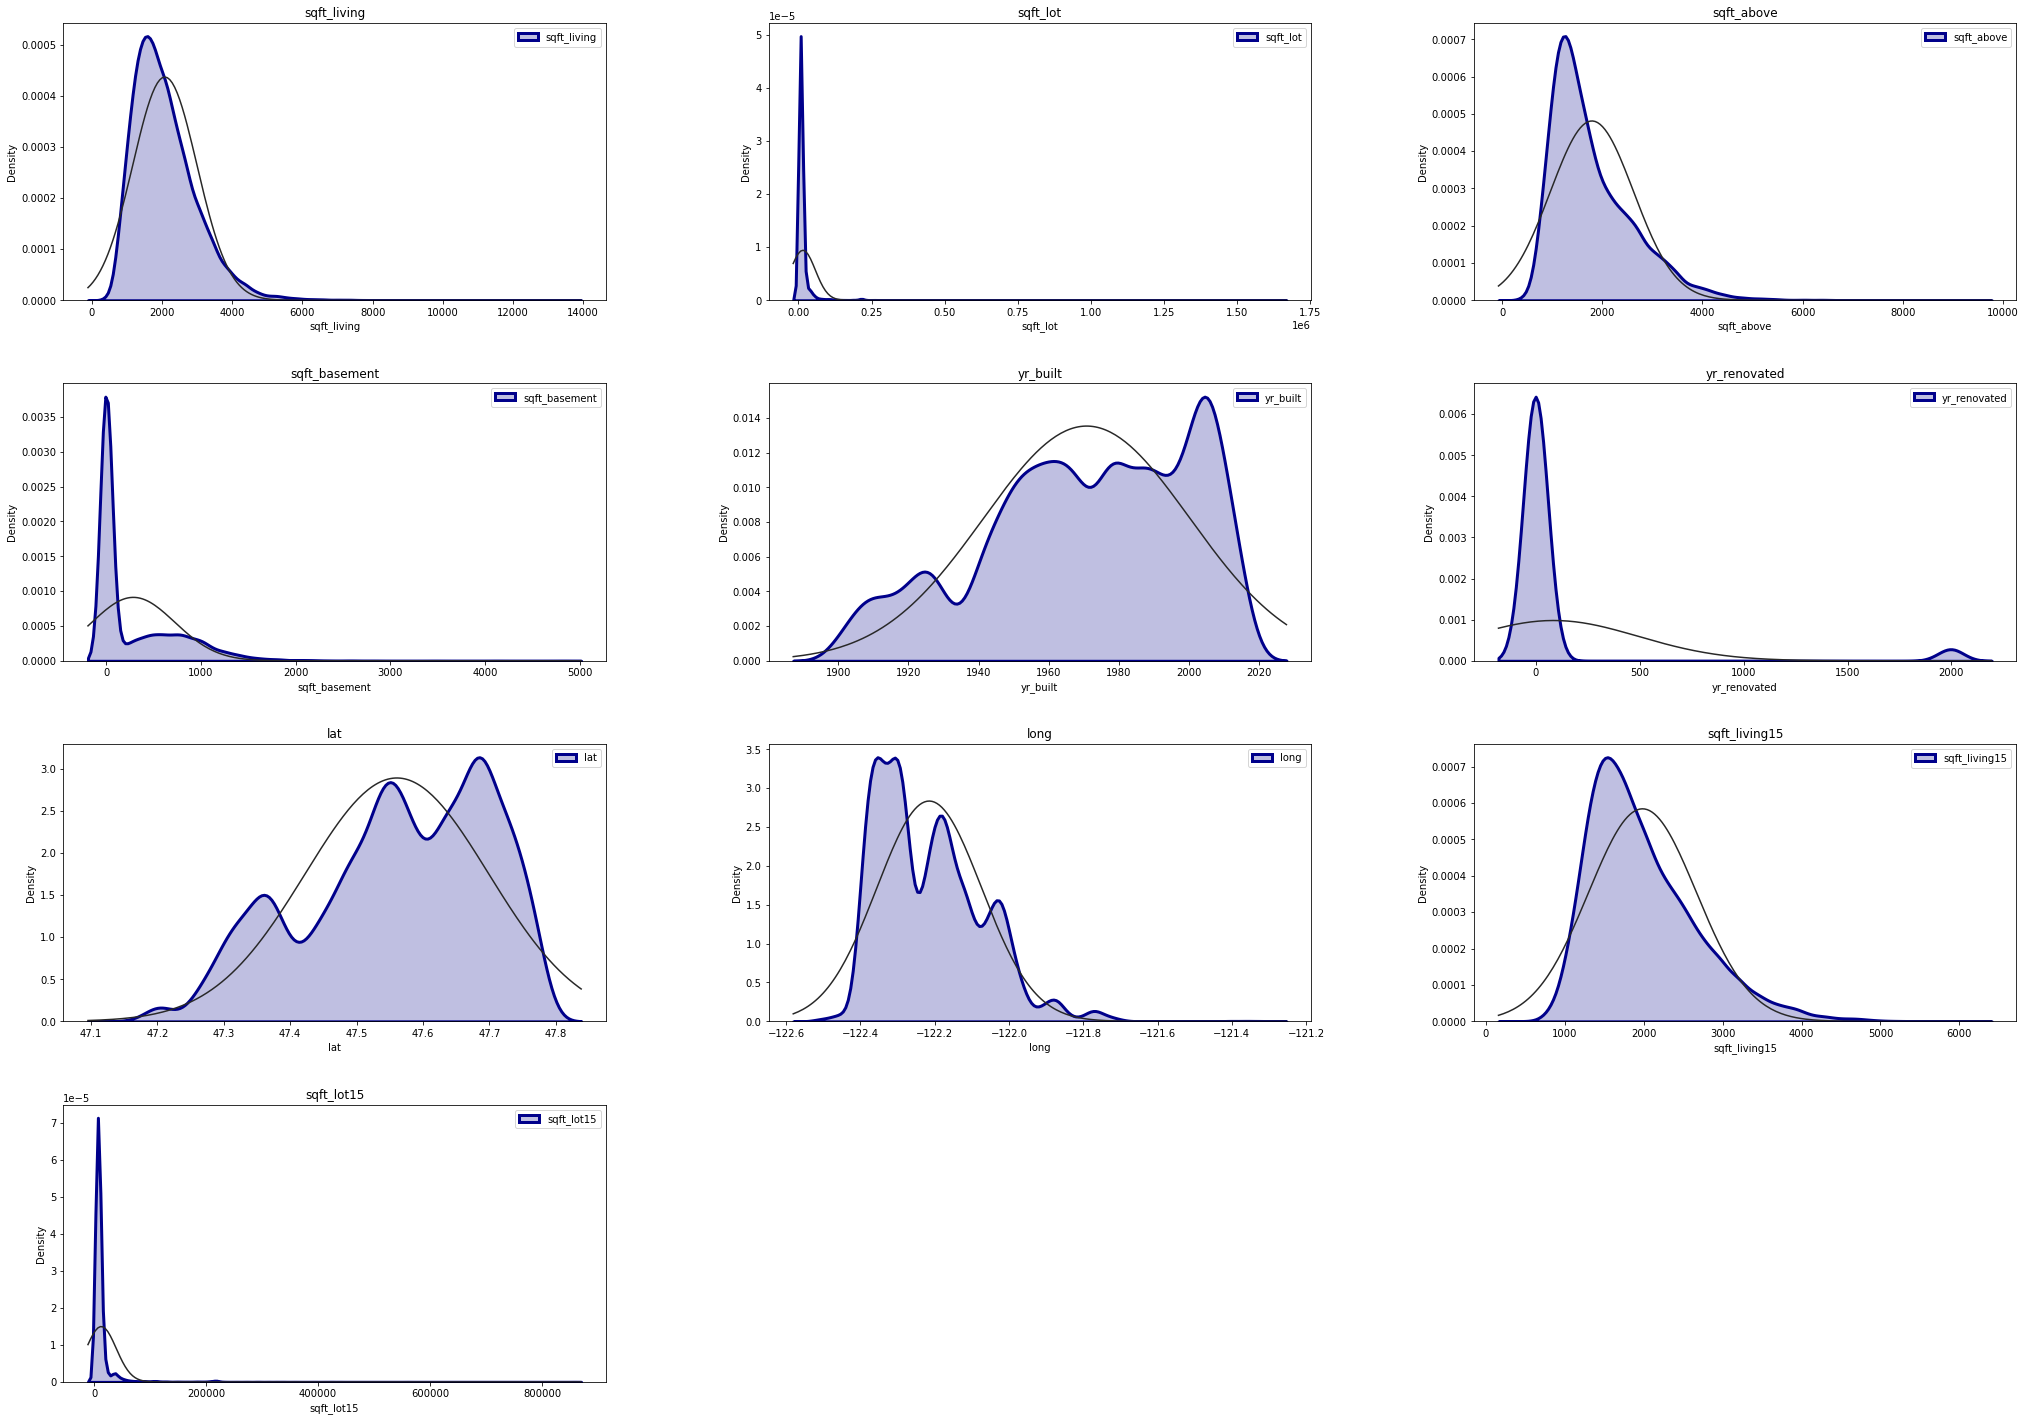

In [37]:
# plot the kde of numerical features
def plot_kde(data:pd.DataFrame, cols:list):
    """
    Plot the kde of numerical features
        
        Parameters
        ----------
        data : DataFrame
        cols : list of features
    """

    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)
    

    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.distplot(data[col], fit=stats.norm, hist=False, kde=True, 
                     kde_kws={'linewidth': 3, 'shade': True, 'color': 'darkblue'}, 
                     label=col, ax=ax)        
        plt.title(col)
        plt.legend()

plot_kde(df_train, numerical_feat)


In [38]:
# def plot_dist_plot(data:pd.Series) -> None:
#     _, ax = plt.subplots(1,2, figsize=(15,7))
#     sns.distplot(a=data, fit=stats.norm, ax=ax[0])
#     ax[0].set_title('price before transformation to normaly')
#     sns.distplot(a=np.log(data), fit=stats.norm, ax=ax[1])
#     ax[1].set_title('price after transformation to normaly')

# plot_dist_plot(df_train['price'])

### Categorical variables

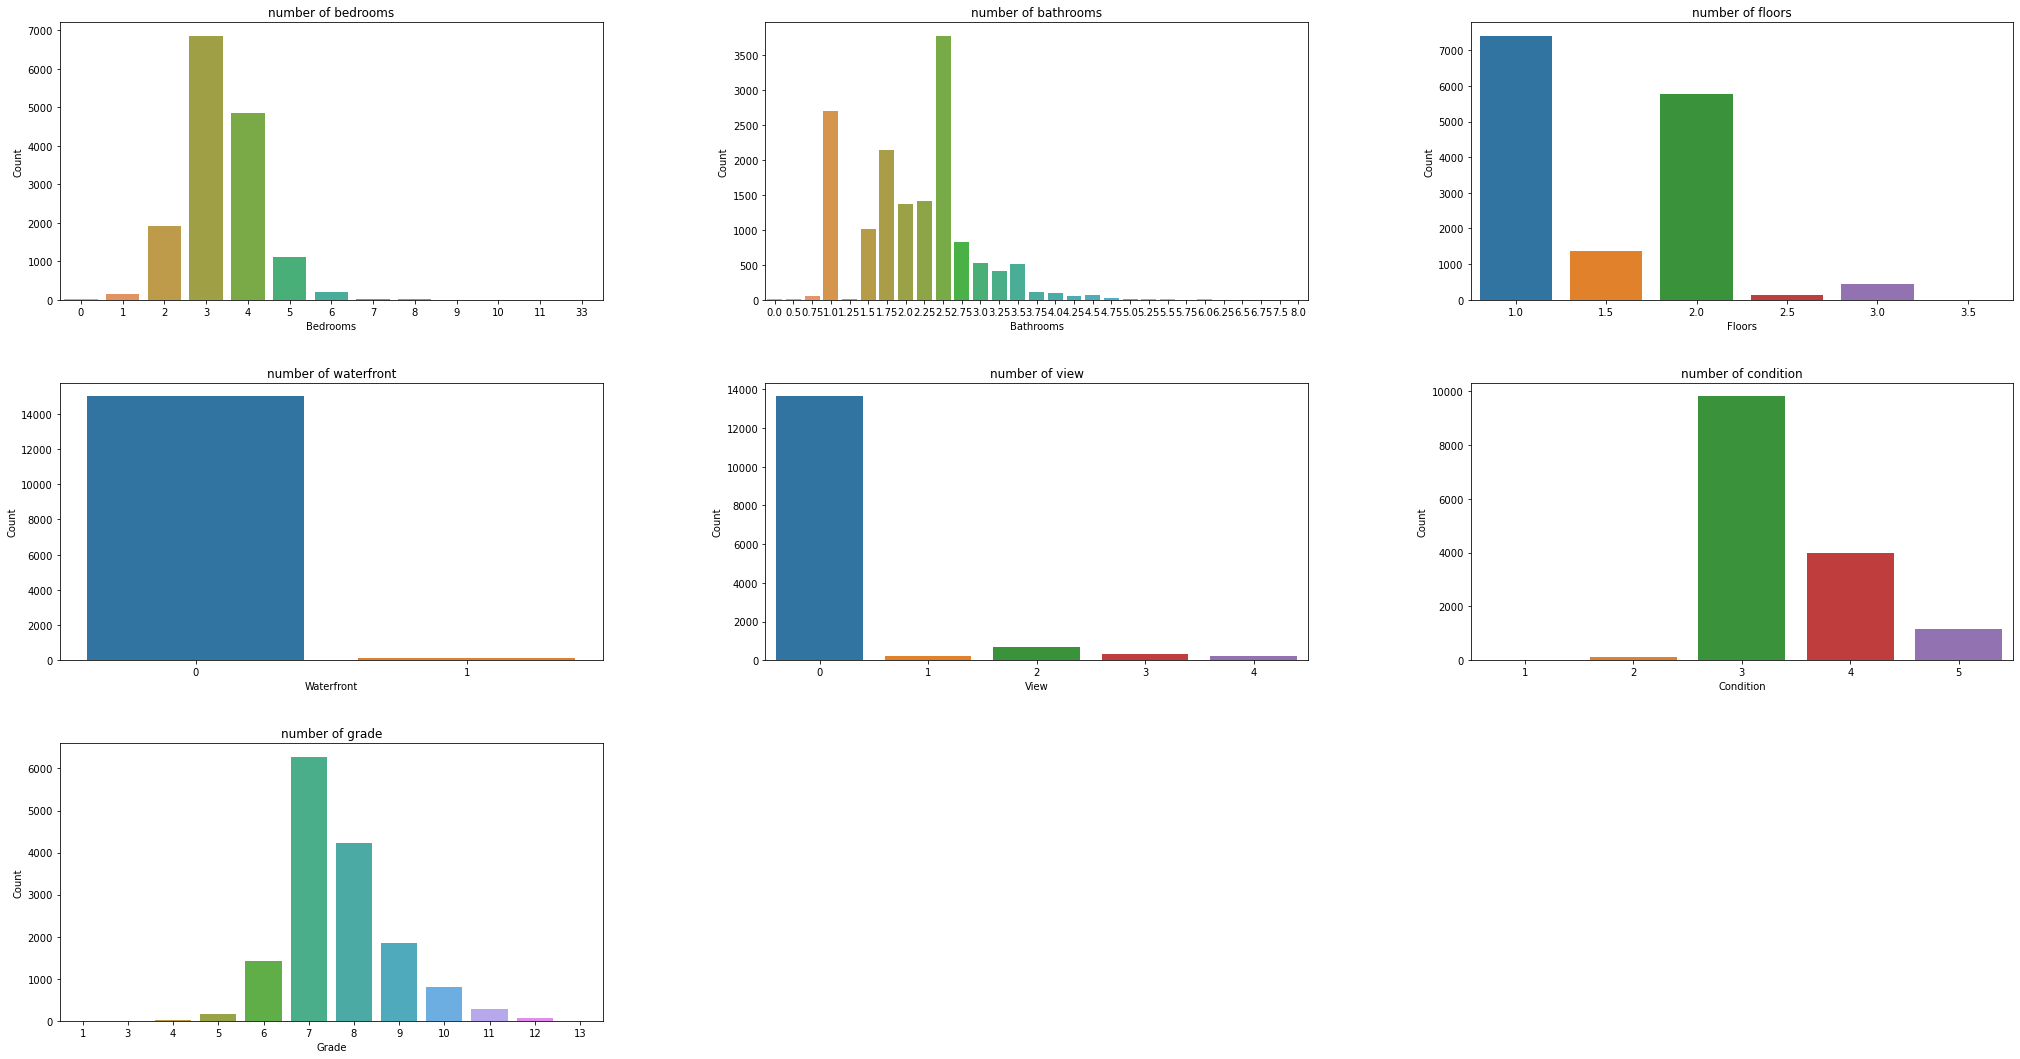

In [17]:
# plot countplot for categorical features
def plot_count_plot(data:pd.DataFrame):
    """
    Plot countplot for categorical features
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    """
    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(data.columns, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.countplot(x=col, data=data, ax=ax)
        ax.set_title(f'number of {col}')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Count')
        

plot_count_plot(df_train[categorical_feat])

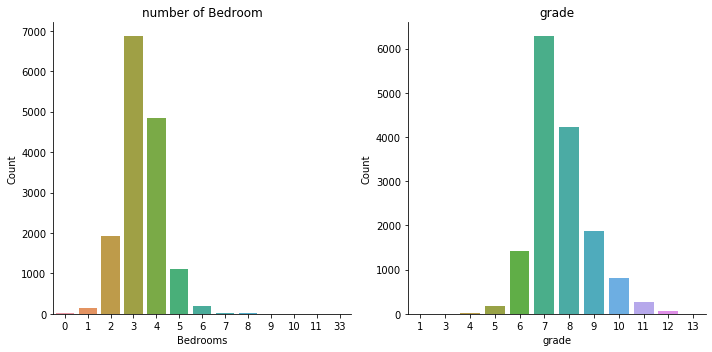

In [44]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(x='bedrooms', data=df_train, ax=ax[0])



sns.countplot(x='grade', data=df_train, ax=ax[1])
ax[1].set_title('grade')
ax[1].set_xlabel('grade')
ax[1].set_ylabel('Count')
sns.despine()
plt.tight_layout()

# Bivariate analysis

## continuous - continuous variables

We notice that there is a good relation between **price** and **(sqft_living, sqft_living15, sqft_above, bathrooms, long)** and a poor realtion with **(lat, bathrooms, yr_built)** 

### Lat - long

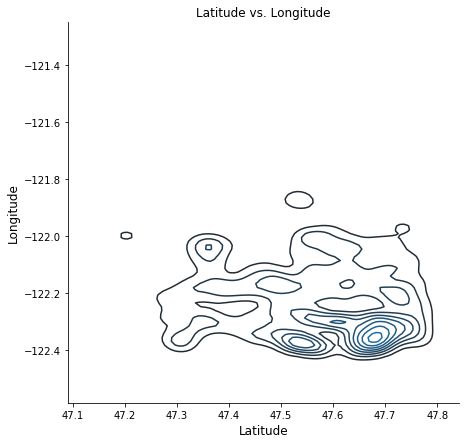

In [13]:
plt.figure(figsize=(7,7))
sns.kdeplot(data=df_train['lat'], data2=df_train['long'])
plt.title("Latitude vs. Longitude")
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
sns.despine()


### price - continuous vars

In [18]:
# plot scatter plot between price and continues variables
def plot_scatter_plot(data:pd.DataFrame):
    """
    Plot scatter plot between price and continues variables
    
    Parameters
    ----------
    data : DataFrame
    """
    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(data.columns, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.regplot(x=col, y='price', data=data, ax=ax)
        ax.set_title(f'price vs {col}')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('price')

plot_count_plot(df_train[numerical_feat - ['price']])
# sns.scatterplot(x='sqft_living', y='sqft_above', data=df_train)

TypeError: Cannot broadcast np.ndarray with operand of type <class 'list'>

#### There is a positive linear correlation between sqft_living and sqft_above so we can delete one of them

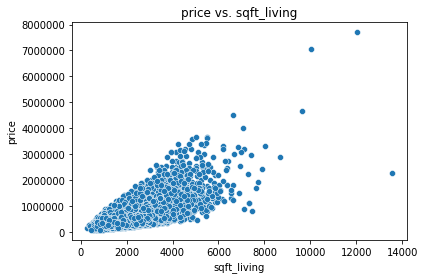

In [50]:
sns.scatterplot(x='sqft_living', y='price', data=df_train)
plt.title("price vs. sqft_living");

#### There is a point that represents an outlier at (sqft_living > 13000) so we should deleted

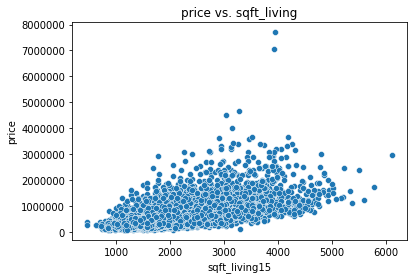

In [51]:
sns.scatterplot(x='sqft_living15', y='price', data=df_train)
plt.title("price vs. sqft_living");

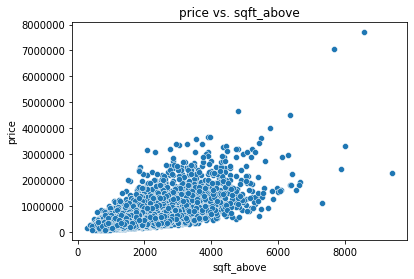

In [52]:
sns.scatterplot(x='sqft_above', y='price', data=df_train)
plt.title("price vs. sqft_above");

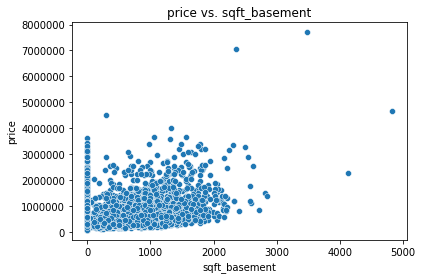

In [53]:
sns.scatterplot(x='sqft_basement', y='price', data=df_train)
plt.title("price vs. sqft_basement");

#### Some values have values eqaul to (0). So, that might mislead the algorithm

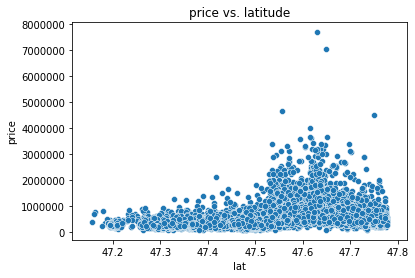

In [54]:
sns.scatterplot(x='lat', y='price', data=df_train)
plt.title("price vs. latitude");

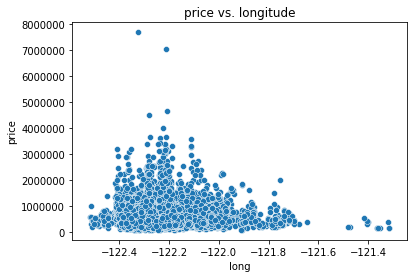

In [55]:
sns.scatterplot(x='long', y='price', data=df_train)
plt.title("price vs. longitude");

#### There is no good correlation between **price** and **long**, so we can eleminate it. 

## 2. Categorical features with target

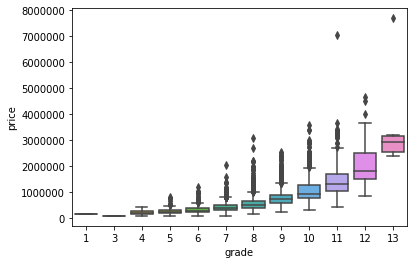

In [56]:
sns.boxplot(x='grade', y='price', data=df_train);

#### We notice that there is a positive correlation between **price** and **grade**

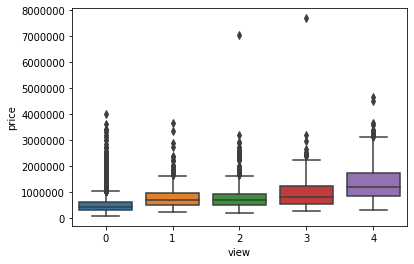

In [57]:
sns.boxplot(x='view', y='price', data=df_train);

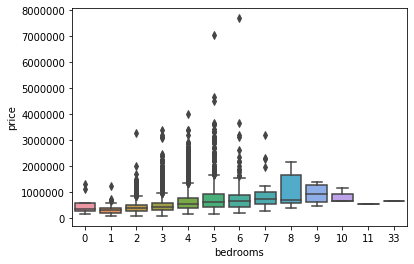

In [10]:
sns.boxplot(x='bedrooms', y='price',  data=df_train);

## Correlation
Based on the **univariate analysis**, spearman correlation coefficient is the best way to check the correlation between the variables because the data is not normally distributed.


From the correlation matrix, the pairs of features with high correlation are:
- price: and sqft_living, sqft_above, sqft_living15
- sqft_living and sqft_above
- sqft_living and sqft_living15
- sqft_above and sqft_living15
- sqft_lot and sqft_lot15




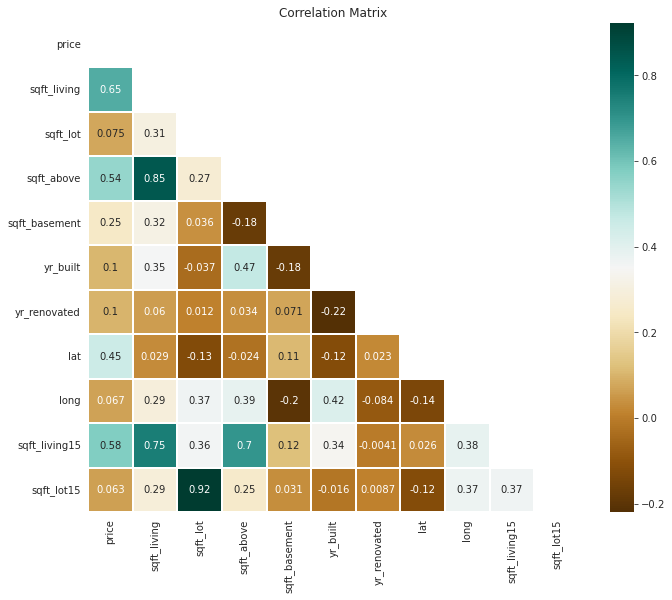

In [ ]:
# Find the spearman correlation between features

corr_mat = df_train[numerical_feat].corr(method='spearman')


mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
  
with sns.axes_style("whitegrid"): # white, dark, whitegrid, darkgrid, ticks
    f, ax = plt.subplots(figsize=(11, 9))
    # sns.heatmap(corr_mat, mask=mask, annot=True, annot_kws={'size':10}, cmap=cmap, vmax=.3, center=0,
    #             square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    ax = sns.heatmap(data=corr_mat, mask=mask, annot=True, annot_kws={'size':10}, linewidths=2, cmap=plt.cm.BrBG)
    ax.set_title('Correlation Matrix')

In [ ]:
def find_corr_feat(corr_mat:np.array,  threshold:float) -> pd.DataFrame:
    """
    Find correlated features that have correlation value bigger than the threshold
        
        Parameters
        ----------
        data : DataFrame
        threshold : float
        
        Returns
        -------
        correlated_feat : DataFrame contains correlated features
    """
        

    corr_vars = set()

    # we search for correlated values in triangular shape
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if(abs(corr_mat.iloc[i,j]) > threshold):
                corr_vars.add((corr_mat.columns[i], corr_mat.index[j]))
        
    return pd.DataFrame(corr_vars, columns=['feat1', 'feat2'])

# corr_vars = findCorrVars(X_train_new, 0.7)
# print("The most correlate features are: ", corr_vars)
find_corr_feat(corr_mat, 0.6)

,feat1,feat2
0,sqft_living,price
1,sqft_living15,sqft_above
2,sqft_above,sqft_living
3,sqft_lot15,sqft_lot
4,sqft_living15,sqft_living


# Multivariate

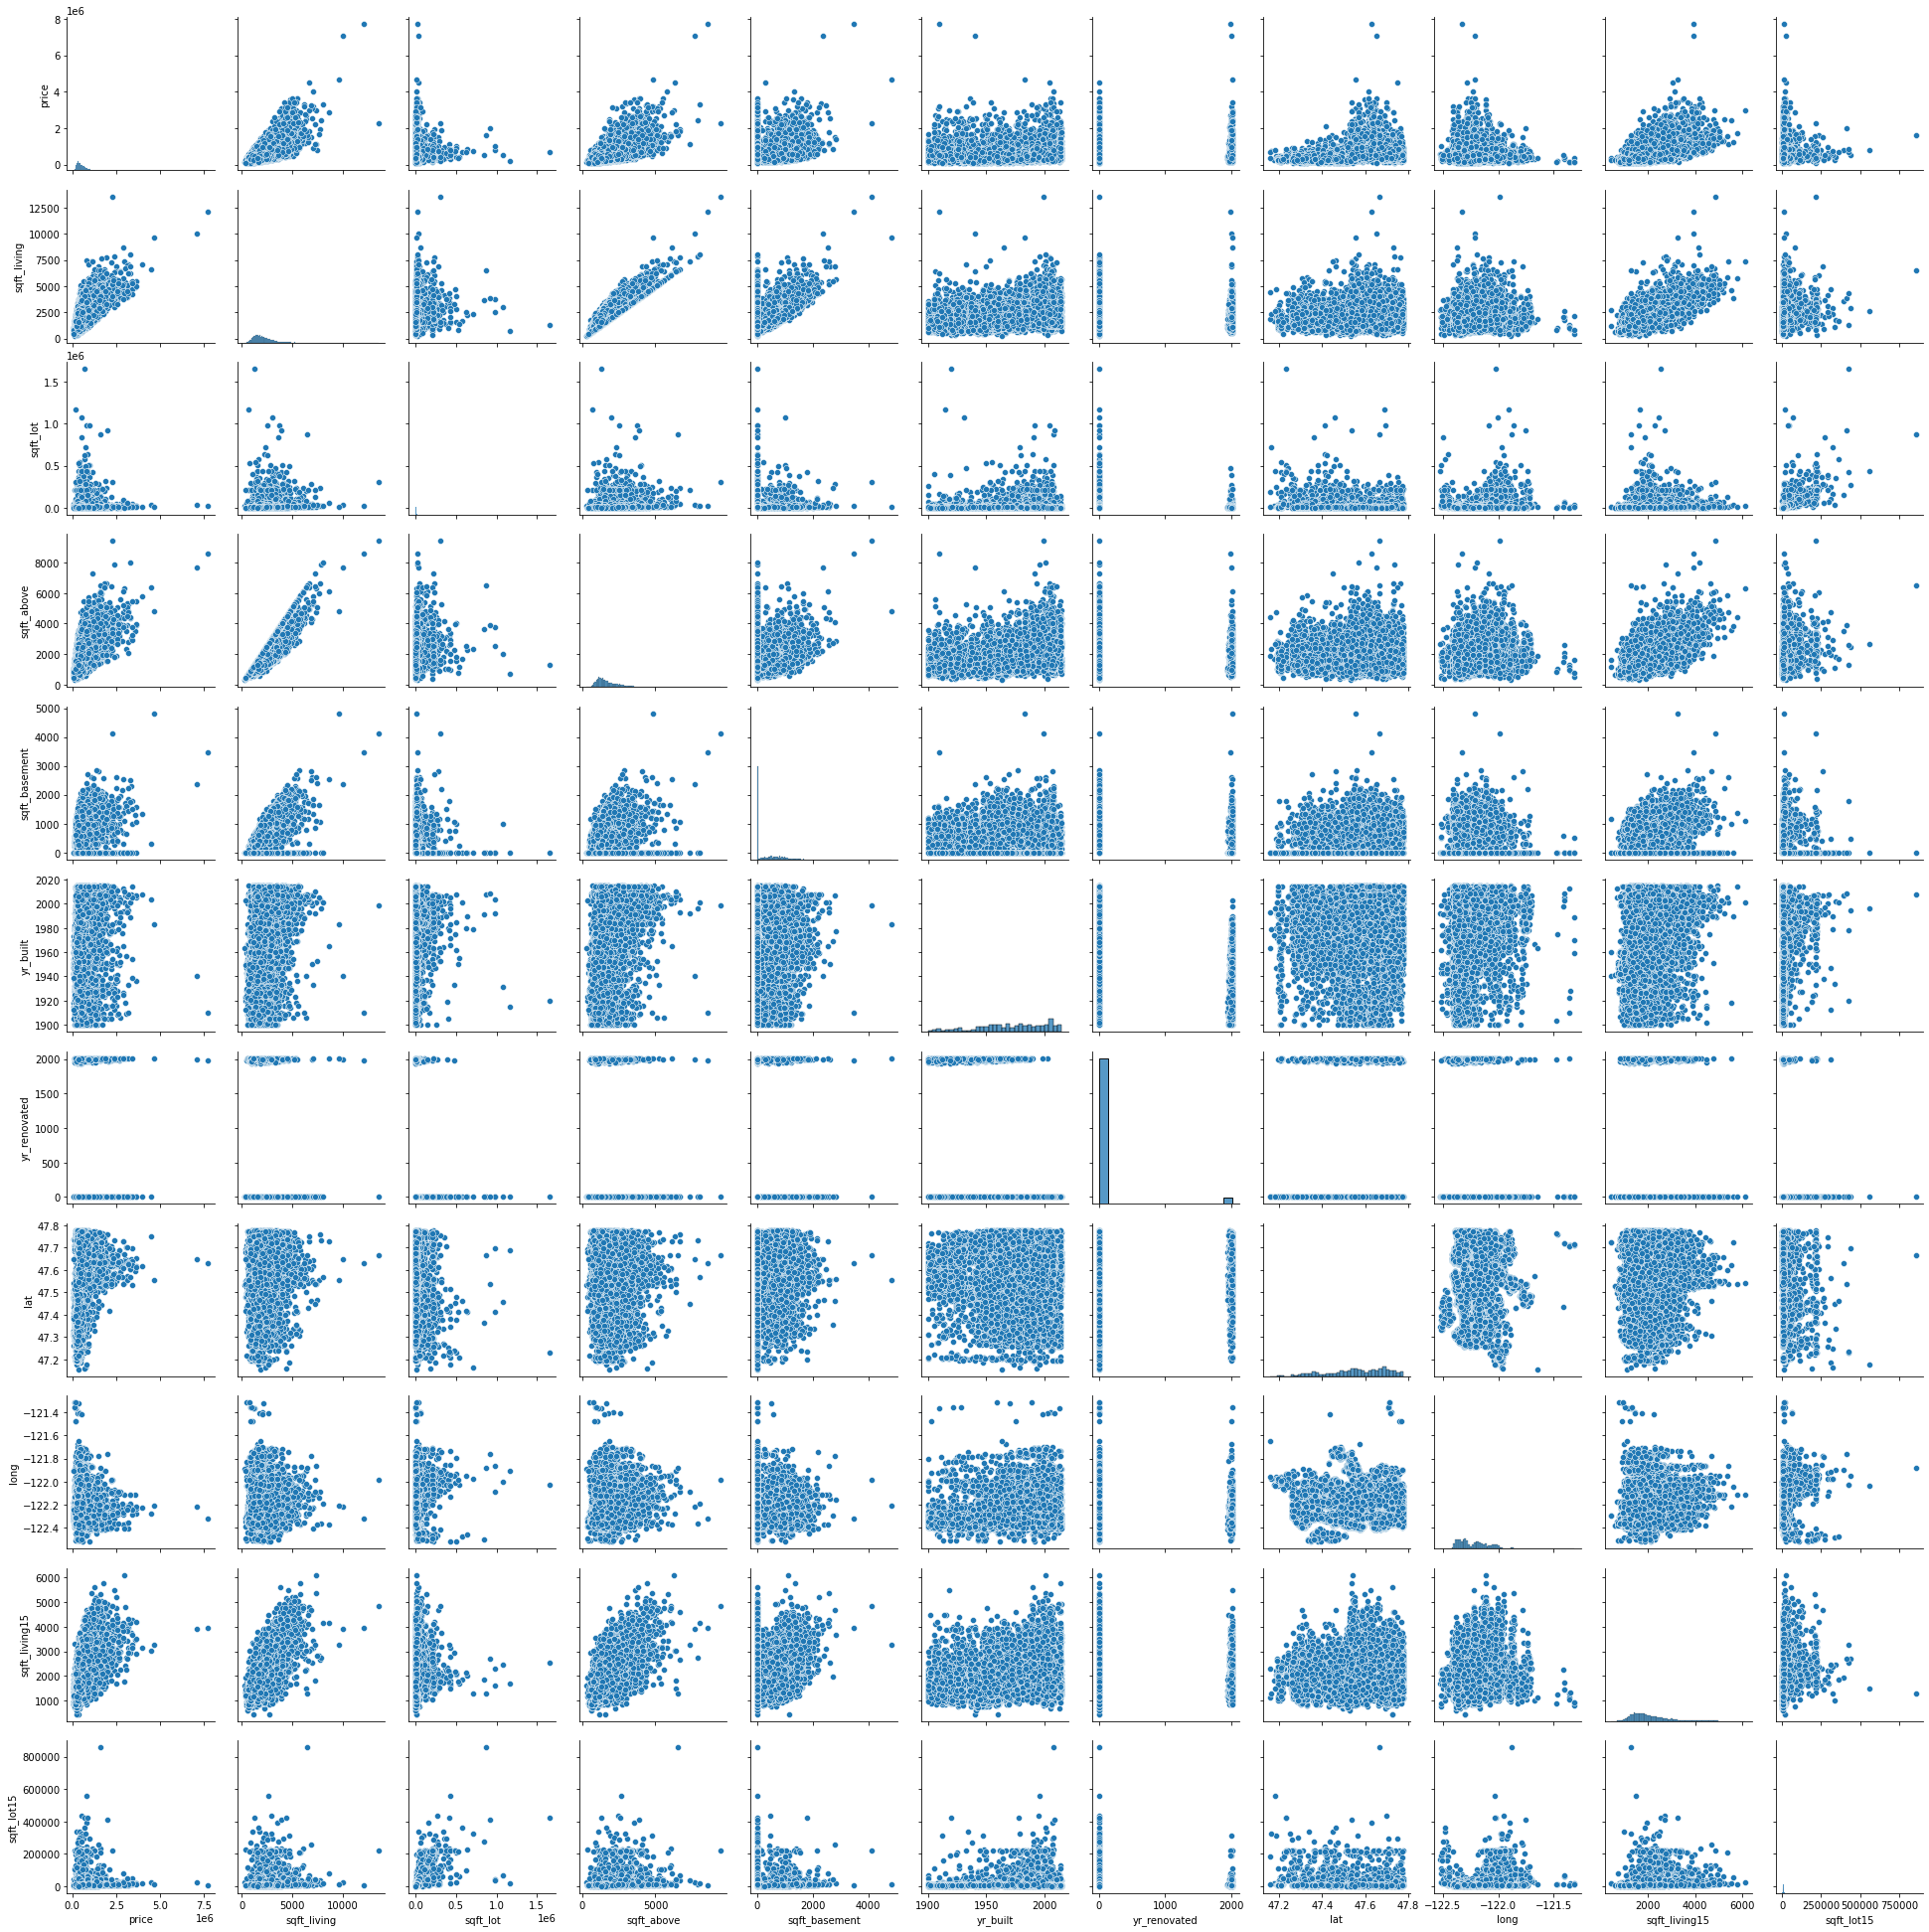

In [44]:
sns.pairplot(data=df_train[numerical_feat], palette='RdYlGn')

#### No missing values were found

In [76]:
# print("Training data shape before delete values: ",X_train.shape)
# X_train_new = X_train.drop(index=X_train[X_train['sqft_basement']==0].index)
# y_train_new = y_train.drop(index=y_train[X_train['sqft_basement']==0].index)
# print("Training data shape after delete values: ",X_new.shape)

In [17]:
X_train_new = X_train.copy()
y_train_new = y_train.copy()
X_test_new = X_test.copy()
y_test_new = y_test.copy()

# Features Transformation
#### We will transform some continues features to normal distribution

In [18]:
rng = np.random.RandomState(304)

# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)

X_train_new[numerical_feat] = qt.fit_transform(X_train_new[numerical_feat])
X_test_new[numerical_feat] = qt.transform(X_test_new[numerical_feat])

y_train_new = pd.Series(qt.fit_transform(y_train_new.to_numpy()[:,np.newaxis]).ravel(), name='price')
y_test_new = pd.Series(qt.transform(y_test_new.to_numpy()[:,np.newaxis]).ravel(), name='price')


# Outliers

#### Our analysis revealed that there were many outliers should be deleleted:
- There is tow points that represents an outlier at (price > 700000).
- There is a point that represents an outlier at (sqft_living > 13000).

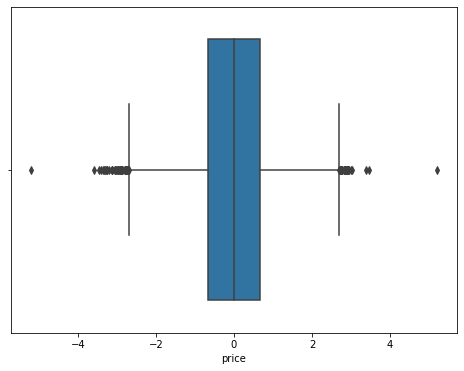

In [19]:
# before removing outliers
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new) #bedrooms, floors, waterfront, view, yr_renovated

#### There are some outliers in price that should be deleted

### 1. Using Z-Score

In [20]:
z = np.abs(stats.zscore(y_train_new))
dropped_rows = np.where(z > 3)[0]

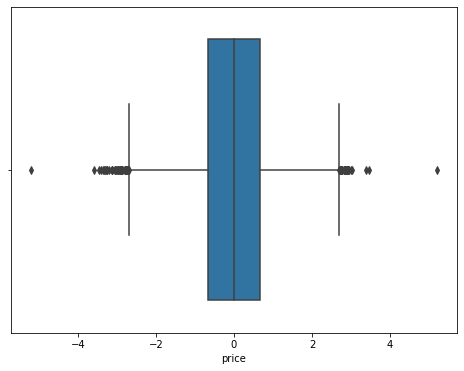

In [21]:
# After using z-score to remove outliers
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new) #bedrooms, floors, waterfront, view, yr_renovated

### 2. Using IQR

In [102]:
Q1, Q3 = np.percentile(a=y_train_new, q=[25,75], interpolation='midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(y_train_new >= (Q3+1.5*IQR))[0]
# Lower bound
lower = np.where(y_train_new <= (Q1-1.5*IQR))[0]

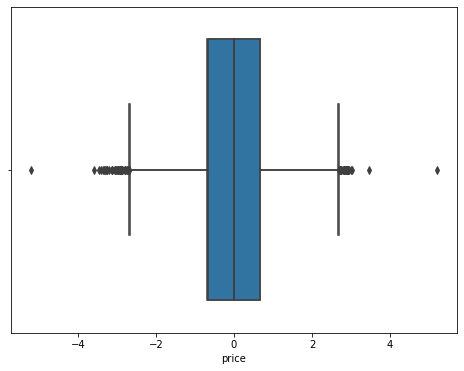

In [103]:
# After using IQR to remove outliers
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new.drop(index=upper)) #bedrooms, floors, waterfront, view, yr_renovated
sns.boxplot(x=y_train_new.drop(index=lower)) #bedrooms, floors, waterfront, view, yr_renovated

### 3. Using Visualization

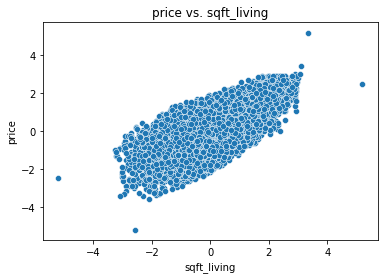

In [15]:
sns.scatterplot(x='sqft_living', y='price', data=pd.concat([X_train_new, y_train_new], axis=1))
plt.title("price vs. sqft_living");

In [16]:
ind = y_train_new[abs(y_train_new)>4].index

X_train_new = X_train_new.drop(index=ind)
y_train_new = y_train_new.drop(index=ind)

X_train_new.reset_index(drop=True, inplace=True)
y_train_new.reset_index(drop=True, inplace=True)

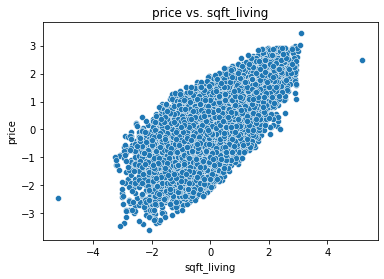

In [17]:
# After using visualization technique to remove outliers
sns.scatterplot(x='sqft_living', y='price', data=pd.concat([X_train_new, y_train_new], axis=1))
plt.title("price vs. sqft_living");

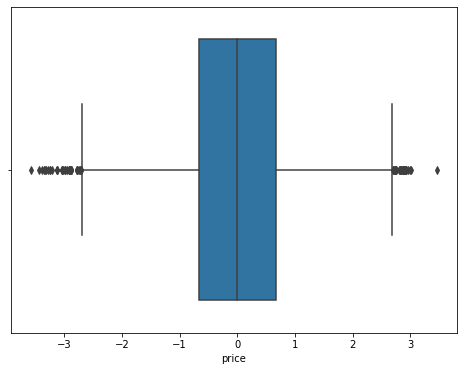

In [18]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new) #bedrooms, floors, waterfront, view, yr_renovated

### 4. Isolation Forest method

In [19]:
iso = IsolationForest(n_jobs=-1)
iso_outliers_index = iso.fit_predict(X_train_new[numerical_feat])
print("Training data shape before removing outliers:", X_train_new.shape)
print("Training data shape after removing outliers:", X_train_new[iso_outliers_index == 1].shape)

Training data shape before removing outliers: (15127, 18)
Training data shape after removing outliers: (13489, 18)


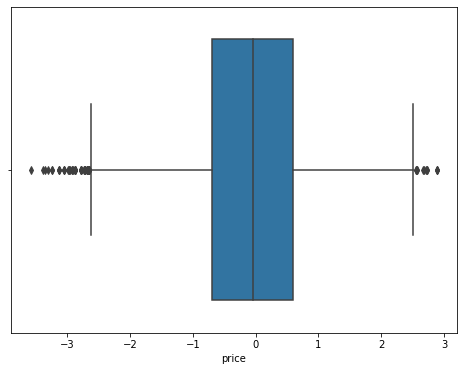

In [20]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new[iso_outliers_index == 1]) #bedrooms, floors, waterfront, view, yr_renovated

### 5. Local Outlier Factor method 

In [21]:
lof = LocalOutlierFactor(n_jobs=-1)
lof_outliers_index = lof.fit_predict(X_train_new[numerical_feat])
print("Training data shape before removing outliers:", X_train_new.shape)
print("Training data shape after removing outliers:", X_train_new[lof_outliers_index == 1].shape)

Training data shape before removing outliers: (15127, 18)
Training data shape after removing outliers: (14734, 18)


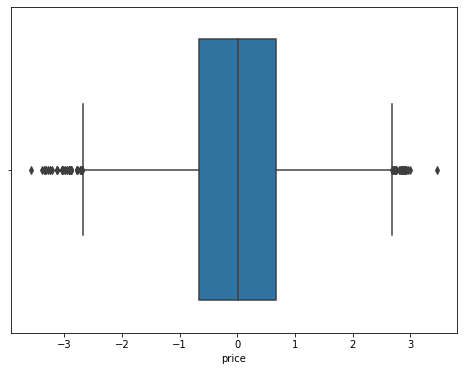

In [22]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=y_train_new[lof_outliers_index == 1]) #bedrooms, floors, waterfront, view, yr_renovated

In [23]:
X_train_new, y_train_new = X_train_new[iso_outliers_index == 1], y_train_new[iso_outliers_index == 1]
X_train_new.reset_index(drop=True, inplace=True)
y_train_new.reset_index(drop=True, inplace=True)


# Features scaling

In [22]:
scaler = StandardScaler()
X_train_new[numerical_feat] = scaler.fit_transform(X_train_new[numerical_feat], y_train_new)
X_test_new[numerical_feat] = scaler.transform(X_test_new[numerical_feat])

y_train_new = pd.Series(scaler.fit_transform(y_train_new.to_numpy()[:,np.newaxis]).ravel(), name='price')
y_test_new = pd.Series(scaler.transform(y_test_new.to_numpy()[:,np.newaxis]).ravel(), name='price')

# Features selection

### 1. Filter method

In [23]:
skb_freg = SelectKBest(score_func=f_regression, k=13)
skb_freg.fit(X_train_new, y_train_new)
skb_freg_selected_feat = pd.DataFrame({'score':skb_freg.scores_, 'p-value':skb_freg.pvalues_, 'accepted':skb_freg.get_support()}, index=X_train_new.columns)
skb_freg_selected_feat[skb_freg.get_support()]

,score,p-value,accepted
bedrooms,2262.48021,0.00000e+00,True
bathrooms,7006.45152,0.00000e+00,True
sqft_living,14178.21794,0.00000e+00,True
sqft_lot,178.33996,1.77210e-40,True
floors,1914.86270,0.00000e+00,True
waterfront,347.73381,7.48737e-77,True
view,1954.30688,0.00000e+00,True
grade,15686.78375,0.00000e+00,True
sqft_above,8480.22560,0.00000e+00,True
sqft_basement,1016.08611,1.02506e-216,True


### 2. Feature importance method

In [24]:
skb_mi = SelectKBest(score_func=mutual_info_regression, k=13)
skb_mi.fit(X_train_new, y_train_new)
skb_mi_selected_feat = pd.DataFrame({'score':skb_mi.scores_, 'accepted':skb_mi.get_support()}, index=X_train_new.columns)
skb_mi_selected_feat[skb_mi.get_support()]

,score,accepted
bedrooms,0.07762,True
bathrooms,0.20231,True
sqft_living,0.34118,True
floors,0.07981,True
grade,0.34984,True
sqft_above,0.25759,True
sqft_basement,0.07112,True
yr_built,0.08036,True
zipcode,0.43084,True
lat,0.33241,True


In [25]:
skb = skb_freg
X_train_new = pd.DataFrame(skb.transform(X_train_new), columns=X_train_new.columns[skb.get_support()])
X_test_new = pd.DataFrame(skb.transform(X_test_new), columns=X_test_new.columns[skb.get_support()])


### 3. Correlation matrix

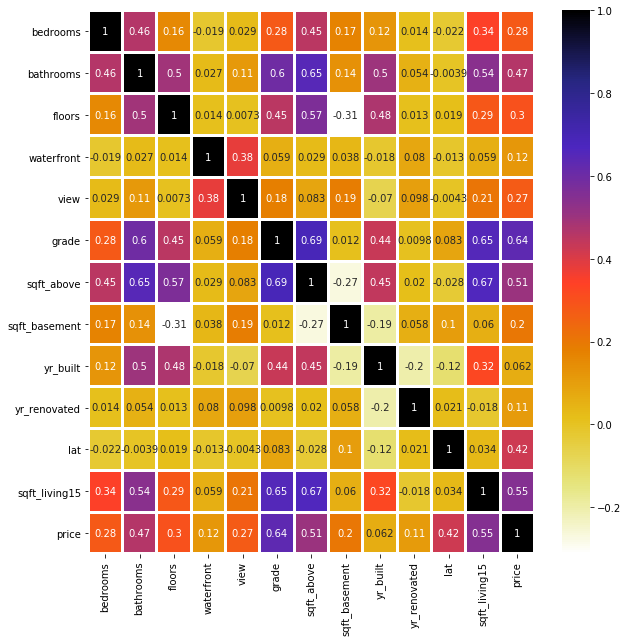

In [46]:
corr_mat = pd.concat([X_train_new, y_train_new], axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(data=corr_mat, annot=True, annot_kws={'size':10}, linewidths=2, cmap=plt.cm.CMRmap_r)

In [37]:
# Create function to find correlated features that have correlation value bigger than the threshold
def findCorrVars(data, threshold):
    corr_vars = set()
    corr_mat = data.corr()
    # we search for correlated values in trianglar shape
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if(abs(corr_mat.iloc[i,j]) > threshold):
                corr_vars.add(corr_mat.columns[i])
        
    return list(corr_vars)

corr_vars = findCorrVars(X_train_new, 0.7)
print("The most correlate features are: ", corr_vars)

The most correlate features are:  ['sqft_living15', 'sqft_living', 'grade', 'sqft_above']


#### We can delete 'sqft_living' because is correlated with 'sqft_above' and less correlated with traget

In [38]:
X_train_new.drop(columns=corr_vars[0], inplace=True)
X_test_new.drop(columns=corr_vars[0], inplace=True)

# Modeling

In [26]:
randomForest_model = RandomForestRegressor(n_estimators = 100, max_depth=8, n_jobs=-1)
randomForest_model.fit(X_train_new,y_train_new)

print("Model train score: ",randomForest_model.score(X_train_new,y_train_new))
print("Model validation score: ",randomForest_model.score(X_test_new, y_test_new))
print("MSE validation: ", mean_absolute_error(y_test_new, randomForest_model.predict(X_test_new)))

Model train score:  0.8592663523126739
Model validation score:  0.8374483183104235
MSE validation:  0.30330821515333695


In [45]:
gradientBossting_model = GradientBoostingRegressor(n_estimators=100, max_depth = 6)
gradientBossting_model.fit(X_train_new,y_train_new)
print("Model train score: ",gradientBossting_model.score(X_train_new,y_train_new))
print("Model validation score: ",gradientBossting_model.score(X_test_new, y_test_new))
print("MSE validation: ", mean_absolute_error(y_test_new, gradientBossting_model.predict(X_test_new)))

Model train score:  0.890446272195762
Model validation score:  0.8554458696609039
MSE validation:  0.28346607937703466


In [46]:
# Calculate testing score/loss for gradientBossting model 

# Make zeros matrix of the shabe of number of estimators
test_error = np.zeros(gradientBossting_model.n_estimators, dtype=np.float64)

# Calculate score for each estimator
for i, y_pred in enumerate(gradientBossting_model.staged_predict(X_test_new)):
    test_error[i] = gradientBossting_model.loss_(y_test_new, y_pred)


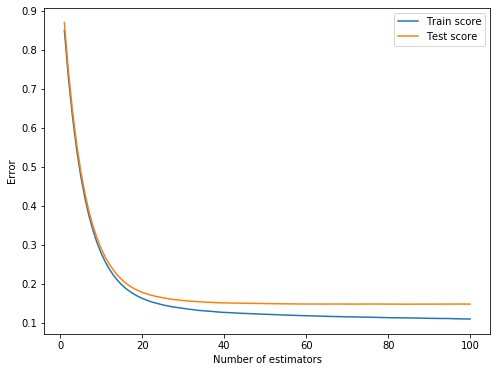

In [47]:
# Ploting score for training and testing
estimators = np.arange(gradientBossting_model.n_estimators)+1

plt.figure(figsize=(8,6))
plt.plot(estimators, gradientBossting_model.train_score_, label='Train score')
plt.plot(estimators, test_error, label='Test score')
plt.xlabel('Number of estimators')
plt.ylabel('Error')
plt.legend()

#### From the above plot we can determine that the number of estimators shoude be selected about 60 estimators to prevent from going to overfitting problem